In [1]:
# local dependencies
from load import *
from plots import *
from clustering_helpers import *
from constants import *
from helpers import *

%load_ext autoreload
%autoreload 2

***
**Cluster analysis**
***

In this notebook, we will perform cluster analysis on both the PDX and the tumor patient datasets. Before reading this notebook, please make sure you have read the exploratory [data analysis](data_analysis.ipynb). To support the interpretation and evaluation of clustering models, we will compute the [silhouette coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) and the [Davis-Boudin index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html). For the labeled PDX dataset we will also compute the [adjusted Rand index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).
The clustering methods used here are [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans), and [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html?highlight=spectralclustering#sklearn.cluster.SpectralClustering).

Please refer to [`clustering_helpers.py`](./clustering_helpers.py) for documentation and implementation of helper functions.

***PDX dataset***

Let's first run the analysis on the raw data:

In [2]:
pdx = load_pdx()
X_pdx = pdx.drop(columns="label")
y_pdx = pdx.label

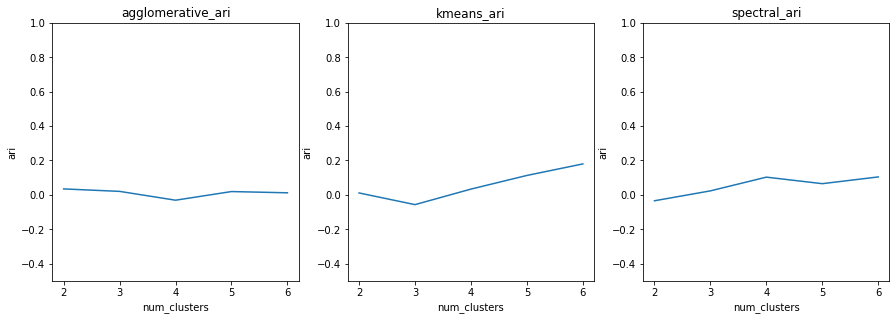

In [3]:
pdx_scores = run_cluster_analysis(X_pdx, y_pdx)

In [4]:
pdx_scores.to_latex(open("../results/pdx_scores.tex", "w"))
pdx_scores

ari                
  agglomerative kmeans spectral
k                              
2         0.034  0.011   -0.035
3         0.020 -0.057    0.023
4        -0.031  0.033    0.103
5         0.019  0.113    0.065
6         0.012  0.180    0.104

Now, let's run the analysis on the standardized data (per tumor):

In [5]:
X_pdx_stdized = pdx_standardize(X_pdx)

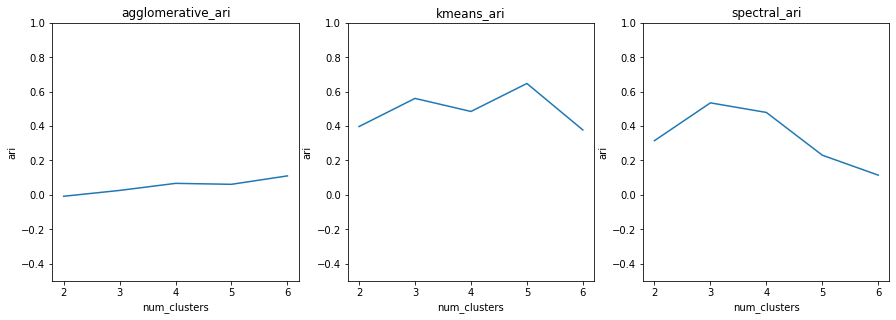

In [6]:
pdx_stdized_scores = run_cluster_analysis(X_pdx_stdized, y_pdx)

In [7]:
pdx_stdized_scores.to_latex(open("../results/pdx_stdized_scores.tex", "w"))
pdx_stdized_scores

ari                
  agglomerative kmeans spectral
k                              
2        -0.008  0.397    0.315
3         0.026  0.560    0.534
4         0.067  0.484    0.479
5         0.061  0.647    0.230
6         0.110  0.377    0.114

We observe that the ARI score is higher for the standardized data, especially for *K-means*.

The number of clusters we are looking for is 3, since we have three hormones/labels. Let's see how the methods perform without the `ctrl` label.

In [8]:
X_pdx_stdized_noctrl = X_pdx_stdized.drop('ctrl')
y_pdx_noctrl = y_pdx.drop('ctrl')

First, we will find the optimal initial centroids for K-means and Spectral clustering, and then apply those optimal centroids.

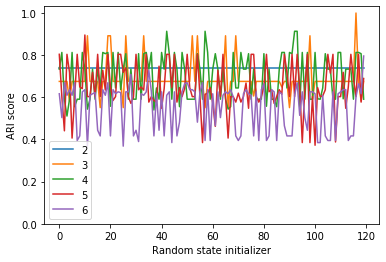

kmeans clustering, max score: 1.0
Optimum random state resulting in the best ARI score: 116
Max ARI score for 2 clusters: 74.0%
Max ARI score for 3 clusters: 100.0%
Max ARI score for 4 clusters: 91.0%
Max ARI score for 5 clusters: 90.0%
Max ARI score for 6 clusters: 80.0%


In [9]:
kmeans_opt_state = optimize_ARI(X_pdx_stdized_noctrl, y_pdx_noctrl, n=120, method="kmeans")

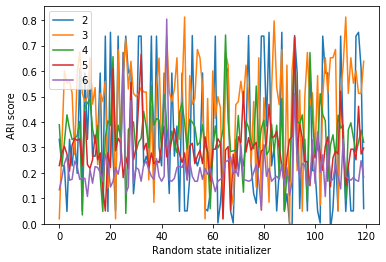

spectral clustering, max score: 0.8122721553698745
Optimum random state resulting in the best ARI score: 49
Max ARI score for 2 clusters: 75.0%
Max ARI score for 3 clusters: 81.0%
Max ARI score for 4 clusters: 74.0%
Max ARI score for 5 clusters: 73.0%
Max ARI score for 6 clusters: 80.0%


In [10]:
spectral_opt_state = optimize_ARI(X_pdx_stdized_noctrl, y_pdx_noctrl, n=120, method="spectral")

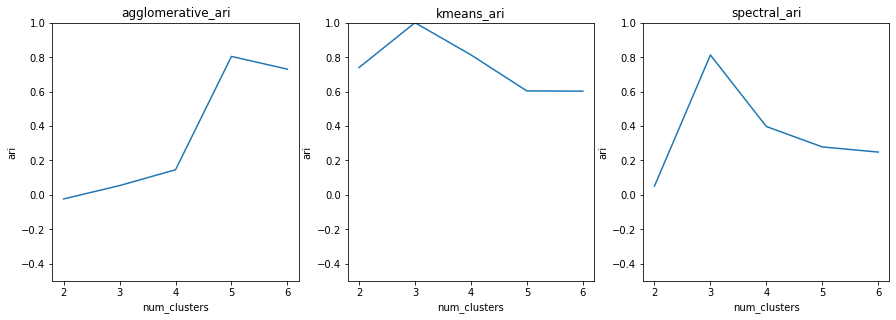

In [11]:
opt_random_states = {
    "kmeans": kmeans_opt_state,
    "spectral": spectral_opt_state,
}
pdx_stdized_noctrl_scores = run_cluster_analysis(X_pdx_stdized_noctrl, y_pdx_noctrl, opt_random_states)

In [12]:
pdx_stdized_noctrl_scores.to_latex(open("../results/pdx_stdized_noctrl_scores.tex", "w"))
pdx_stdized_noctrl_scores

ari                
  agglomerative kmeans spectral
k                              
2        -0.024  0.739    0.051
3         0.054  1.000    0.812
4         0.146  0.813    0.397
5         0.804  0.603    0.278
6         0.730  0.602    0.248

As expected, the methods are better able to cluster when we drop the `ctrl` subjects and use optimum initial centroids. We also observe that the optimal number of clusters is k=3, just as we expect. K-means is perfectly able to classify the samples.

***Patient dataset***

Now, for reference, we will test the same methods on the patient dataset and compute the silhouette and DB scores.

In [13]:
pats = load_patients2()
pats_log_stdized = df_log_standardize_cols(pats)

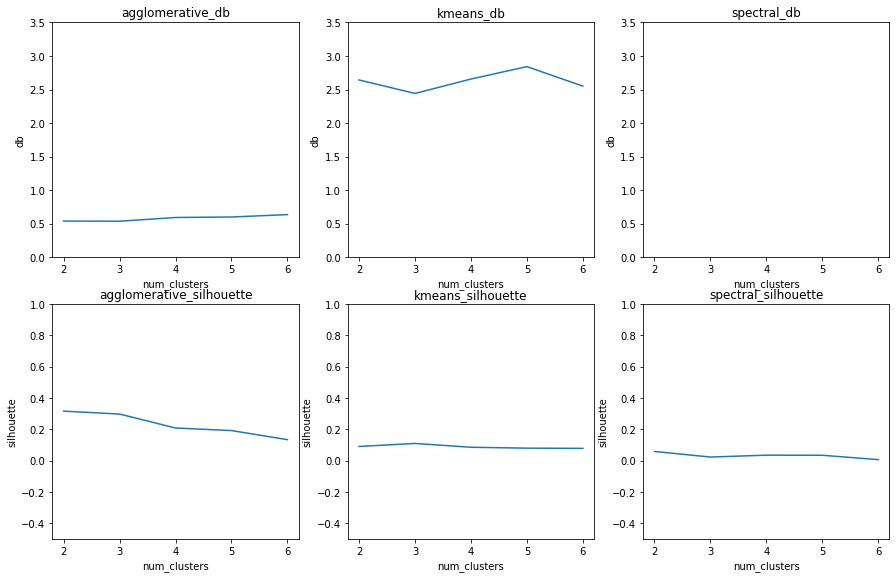

In [30]:
pats_scores = run_cluster_analysis(pats_log_stdized)

In [19]:
pats_scores.to_latex(open("../results/pats_scores.tex", "w"))
pats_scores

,silhouette,db,silhouette,db,silhouette,db
,agglomerative,agglomerative,kmeans,kmeans,spectral,spectral
k,,,,,,
2,0.316,0.539,0.091,2.643,0.043,6.063
3,0.298,0.537,0.110,2.442,0.117,5.516
4,0.209,0.592,0.086,2.656,0.052,10.447
5,0.192,0.600,0.080,2.842,0.002,10.441
6,0.134,0.635,0.079,2.551,0.013,7.404


***
**Applying the best method**
***

Here, we'll apply K-means using 3 clusters on both the PDX and patient datasets. Note, that the optimal random state for the PDX data cannot be applied to the patient data.

***PDX dataset***

In [20]:
clus = cluster.KMeans(n_clusters=3, random_state=kmeans_opt_state)
predicted = clus.fit_predict(X_pdx_stdized_noctrl)

ari_score = metrics.adjusted_rand_score(y_pdx_noctrl, predicted)

describe_prediction(predicted, y_pdx_noctrl)

print(f"ARI score: {ari_score}")

pca = PCA()
pdx_components = pca.fit_transform(X_pdx_stdized_noctrl)
data = pd.DataFrame(pdx_components[:, :3], columns=["1st PC", "2nd PC", "3rd PC"])
plot_kmeans_patient(
    data,
    y_pdx_noctrl.values,
    dim=3,
    title="Optimal clustering of PDX data",
    filename="pdx-clustering-optimal",
)

Cluster 0 contains:
3 dht samples

Cluster 1 contains:
9 e2 samples

Cluster 2 contains:
11 p4 samples

ARI score: 1.0


**[View plot here](https://plot.ly/~valentin.loftsson/109/)**

***Patient dataset***

First, we take the resulting cluster centroids from applying K-means with k=3 on the PDX samples and compute cluster assignments directly for the patient samples. We then visualize the results.

In [22]:
patients_labels = apply_pdx_centroids_on_patients(
    X_pdx_stdized_noctrl,
    y_pdx_noctrl,
    pats_log_stdized,
    kmeans_opt_state,
    3,
    "PDX-centroids-on-patients",
    "Patient data labeled with PDX centroid",
)
print(patients_labels)

[2 2 2 ... 2 2 2]


**[View plot here](https://plot.ly/~valentin.loftsson/116/)**

Let's visualize the cumulative explained variance of the principal components:

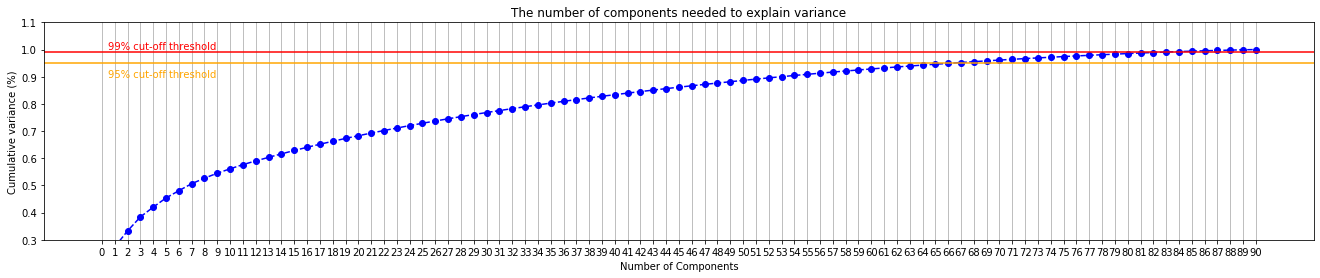

In [23]:
pca.fit(pats_log_stdized)
np.sum(pca.explained_variance_ratio_[:2])
plot_pca_expl_var(pca, 91)

We will now consider clustering with the first 68 components of PCA (since they explain >95% of the variance) in order to reduce the computational cost and to later visualize the clustering with the first 2 and 3 components in 2D and 3D respectively.

In [38]:
pats_components = pca.transform(pats_log_stdized)
pats_pca = pats_components[:, :68]

Finally, let's apply K-means with k=3:

In [40]:
clus = cluster.KMeans(n_clusters=3, random_state=kmeans_opt_state)
predicted = clus.fit_predict(pats_pca)

silhouette = metrics.silhouette_score(pats_pca, predicted, metric='euclidean')
db = metrics.davies_bouldin_score(pats_pca, predicted)

print(f"silhouette is: {silhouette}")
print(f"DB score is: {db}")

silhouette is: 0.11639374757305543
DB score is: 2.3681179677754662


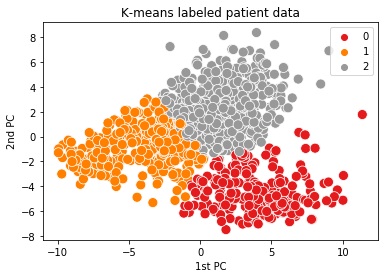

In [41]:
data = pd.DataFrame(pats_pca[:, :2], columns=["1st PC", "2nd PC"])
plot_kmeans_patient(data, predicted, dim=2)

In [42]:
data = pd.DataFrame(pats_pca[:, :3], columns=["1st PC", "2nd PC", "3rd PC"])
plot_kmeans_patient(data, predicted)

**[View plot here](https://plot.ly/~valentin.loftsson/114/#/)**

Overall, we get results comparable to the standardized datasets